<a href="https://colab.research.google.com/github/jainmridul82/Neural-Networks/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tarfile
import os
import PIL

In [ ]:
matplotlib.rcParams['figure.facecolor']='white'
%matplotlib inline

In [ ]:
url="https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz"
torchvision.datasets.utils.download_url(url,".")

Using downloaded and verified file: ./oxford-iiit-pet.tgz


In [ ]:
with tarfile.open("/content/oxford-iiit-pet.tgz","r:gz") as tar:
    tar.extractall("./data")

In [ ]:
DATA_DIR="/content/data/oxford-iiit-pet/images"
files=os.listdir(DATA_DIR)
files[:5]

['Russian_Blue_130.jpg',
 'leonberger_103.jpg',
 'samoyed_197.jpg',
 'Russian_Blue_187.jpg',
 'Maine_Coon_56.jpg']

In [ ]:
len(files)

7393

In [ ]:
def parse_breed(fname):
    parts=fname.split('_')
    return " ".join(parts[:-1])

In [ ]:
print(files[3])
ans=parse_breed(files[3])
print(type(ans),ans)

Russian_Blue_187.jpg
<class 'str'> Russian Blue


In [ ]:
def open_image(path):
    with open(path,'rb') as f:
        img=PIL.Image.open(f)
        return img.convert('RGB')

In [ ]:
DATA_DIR

'/content/data/oxford-iiit-pet/images'

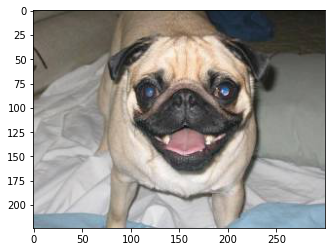

In [ ]:
X=open_image(os.path.join(DATA_DIR,files[70]))
plt.imshow(X)

In [ ]:
print(DATA_DIR+"/"+files[0])
os.path.join(DATA_DIR,files[0])

/content/data/oxford-iiit-pet/images/Russian_Blue_130.jpg


'/content/data/oxford-iiit-pet/images/Russian_Blue_130.jpg'

In [ ]:
class PetsDataset(torch.utils.data.Dataset):
    def __init__(self,root,transform):
        super().__init__()
        self.root=root
        self.transform=transform
        self.files=[fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes=list(set(parse_breed(fname) for fname in files))
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        fname=self.files[i]
        fpath=os.path.join(self.root,fname)
        img=self.transform(open_image(fpath))
        classes_idx=self.classes.index(parse_breed(fname))
        return img,classes_idx

In [ ]:
img_size=224
imagenet_stats=([0.485,0.456,0.406],[0.229,0.224,0.225])

In [ ]:
dataset=PetsDataset(DATA_DIR,torchvision.transforms.Compose([
                torchvision.transforms.Resize(img_size),
                torchvision.transforms.Pad(8,padding_mode='reflect'),
                torchvision.transforms.RandomCrop(img_size),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(*imagenet_stats,inplace=True)
]))

In [ ]:
len(dataset)

7390

In [ ]:
len(dataset.classes)

37

In [ ]:
def denormalize(images,mean,std):
    if len(images.shape)==3:
        images=images.unsqueeze(0)
    means=torch.tensor(mean).reshape(1,3,1,1)
    stds=torch.tensor(std).reshape(1,3,1,1)
    return images*stds+means

In [ ]:
def show_image(img_tensor,label):
    print("Label: ",dataset.classes[label])
    denorm=denormalize(img_tensor,*imagenet_stats)
    plt.imshow(denorm[0].permute(1,2,0))
    plt.show()

Label:  yorkshire terrier


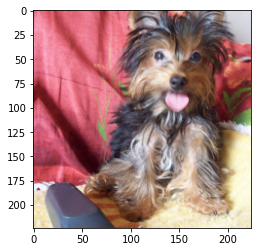

In [ ]:
img,label=dataset[2870]
show_image(img,label)

In [ ]:
val_pct=0.1
val_size=int(val_pct*len(dataset))
train_size=len(dataset)-val_size

train_ds,val_ds=torch.utils.data.random_split(dataset,[train_size,val_size])

In [ ]:
len(train_ds),len(val_ds)

(6651, 739)

In [ ]:
batch_size=128
train_dataloader=torch.utils.data.DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=4)
val_dataloader=torch.utils.data.DataLoader(val_ds,batch_size,pin_memory=True,num_workers=4)

In [ ]:
def show_batch(dataloader):
    for images,_ in dataloader:
        fig,ax=plt.subplots(figsize=(16,16))
        ax.set_xticks([])
        ax.set_yticks([])
        images=denormalize(images,*imagenet_stats)
        X=torchvision.utils.make_grid(images,nrow=16)
        ax.imshow(X.permute(1,2,0))
        break

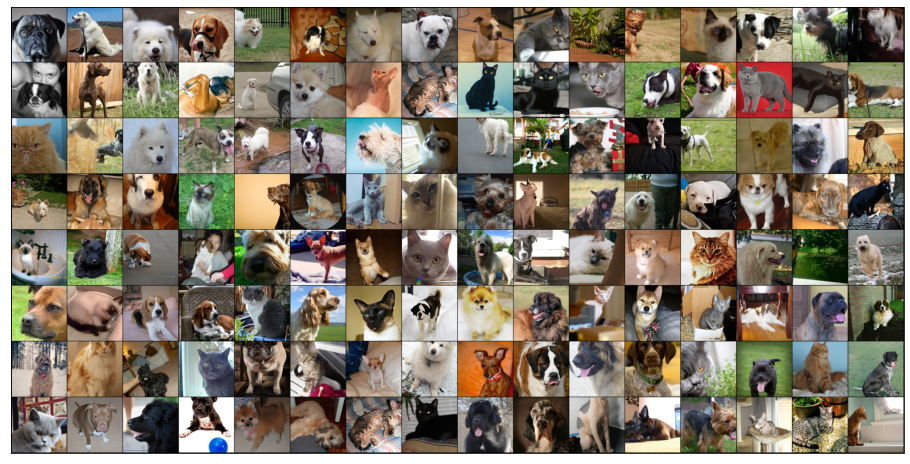

In [ ]:
show_batch(train_dataloader)

In [ ]:
def accuracy(out,labels):
    _,maxl=torch.max(out,dim=1)
    return torch.tensor(torch.sum(maxl==labels).item()/len(labels))

In [ ]:
class ImageClassificationBase(torch.nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=torch.nn.functional.cross_entropy(out,labels)
        return loss
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=torch.nn.functional.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {"val_acc":acc,"val_loss":loss.detach()}
    def validation_epoch_end(self,result):
        loss=[X["val_loss"] for X in result]
        loss_=torch.stack(loss).mean()
        acc=[X["val_acc"] for X in result]
        acc_=torch.stack(acc).mean()
        return {"val_acc":acc_.item(),"val_loss":loss_.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}] {}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,"last_lr: {:.5f}".format(result["lrs"][-1]) if "lrs" in result else 0,result["train_loss"],
            result["val_loss"],result["val_acc"]))

In [ ]:
class PetsModel(ImageClassificationBase):
    def __init__(self,num_classes,pre_trained=True):
        super().__init__()
        self.network=torchvision.models.resnet34(pretrained=pre_trained)
        self.network.fc=torch.nn.Linear(self.network.fc.in_features,num_classes)
    def forward(self,X):
        out=self.network(X)
        return out

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [ ]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [ ]:
device=get_default_device()
print(device)

cuda


In [ ]:
class DeviceLoader:
    def __init__(self,data,device):
        self.data=data
        self.device=device
    def __len__(self):
        return len(self.data)
    def __iter__(self):
        for x in self.data:
            yield to_device(x,self.device)

In [ ]:
@torch.no_grad()
def evaluate(model,val_dataloader):
    model.eval()
    result=[model.validation_step(batch) for batch in val_dataloader]
    return model.validation_epoch_end(result)

In [ ]:
import tqdm

In [ ]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        for batch in tqdm.notebook.tqdm(train_loader):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result=evaluate(model,val_loader)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
def get_lr(optimizer):
    for grps in optimizer.param_groups:
        return grps['lr']

In [ ]:
def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                  weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        lrs=[]
        for batch in tqdm.notebook.tqdm(train_loader):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        result=evaluate(model,val_loader)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        result["lrs"]=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
train_dl=DeviceLoader(train_dataloader,device)
val_dl=DeviceLoader(val_dataloader,device)

In [ ]:
model=PetsModel(len(dataset.classes))
model=to_device(model,device)

In [ ]:
print(model)

PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
history=[evaluate(model,val_dl)]
print(history)

[{'val_acc': 0.040588174015283585, 'val_loss': 3.8476738929748535}]


In [ ]:
epochs=6
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [ ]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,
                  weight_decay,grad_clip,opt_func)


Epoch [0] last_lr: 0.00596, train_loss: 1.5081, val_loss: 11.1116, val_acc: 0.0458



Epoch [1] last_lr: 0.00994, train_loss: 2.0716, val_loss: 2.7536, val_acc: 0.2817



Epoch [2] last_lr: 0.00812, train_loss: 1.5233, val_loss: 1.8780, val_acc: 0.4528



Epoch [3] last_lr: 0.00463, train_loss: 0.9479, val_loss: 1.0479, val_acc: 0.6682



Epoch [4] last_lr: 0.00133, train_loss: 0.5376, val_loss: 0.6967, val_acc: 0.7869



Epoch [5] last_lr: 0.00000, train_loss: 0.3228, val_loss: 0.5980, val_acc: 0.8047
CPU times: user 1min 53s, sys: 1min 7s, total: 3min
Wall time: 7min


In [ ]:
dir(torchvision.models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg